In [88]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import time
from sklearn.linear_model import LinearRegression as lm

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [4]:

    
# FUNCTIONS NEEDED FOR ALL MODELS  ============================================

# function slightly modified from https://nlpforhackers.io/topic-modeling/

def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

def reconstruct_abstract(x):
    return " ".join(x)

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)

def return_top_topics(model, vectorizer, top_n=5):
        ret = []
        for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
            print_list = [vectorizer.get_feature_names()[i].title()  
                        for i in topic.argsort()[:-top_n - 1:-1]]
            ret.append("Topic %d: "%(idx+1)+", ".join(print_list))
        return ret


In [5]:
# DATA INGESTION =========================================================



# import entire dataset

with open(r'../../data/final/final_dataset_7-20.pkl', 'rb') as fp:
    f = pickle.load(fp)
#f = pd.read_csv('../../data/original/working_federal_reporter_2020.csv',engine='python')
f["PROJECT_START_YEAR"] = pd.to_datetime(f["PROJECT_START_DATE"])
f["PROJECT_START_YEAR"] = f["PROJECT_START_YEAR"].apply(lambda x : x.year)
f.loc[pd.isnull(f["PROJECT_START_YEAR"]),"PROJECT_START_YEAR"] = f.loc[pd.isnull(f["PROJECT_START_YEAR"]),"FY.y"]
f["PROJECT_START_YEAR"] = f["PROJECT_START_YEAR"].apply(lambda x : int(x))
df = f[pd.notnull(f["ABSTRACT"]) & (f["PROJECT_START_YEAR"] >= 2008)]#TextCleaning.remove_nulls(raw_df, "ABSTRACT")
#df = df.drop_duplicates()#TextCleaning.remove_duplicates(df)

docs = df["final_frqwds_removed"]

#Uncomment the next two lines to obtain a random 20% sample of the dataset:
#df_samp = df.sample(frac = .2).reset_index()
#docs = df_samp["final_frqwds_removed"]

docs = docs.apply(lambda x : reconstruct_abstract(x))

#docs = df_samp["ABSTRACT"]


In [6]:
# CREATE DOC-TERM MATRIX  ============================================================================

vectorizer = CountVectorizer()#CountVectorizer(max_df=0.4, min_df=3, lowercase=False, max_features=int(len(docs)/2))
doc_term_matrix = vectorizer.fit_transform(docs)


In [7]:
# NMF RUNS ===================================================================================

# create model
num_topics = 15

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 0)
nmf_model.fit_transform(doc_term_matrix)
t2 = time.time()

print(f"  Model time: {t2-t1}")

# print out topics

print_topics(nmf_model, vectorizer, top_n=5)

        


  Model time: 35.20197558403015

Topic 0:
('cell', 47.80103740141997)
('stem', 3.554447384908407)
('differentiation', 1.7851290770544206)
('tissue', 1.7451448059772523)
('immune', 1.667899408040246)

Topic 1:
('health', 28.70902756372539)
('care', 7.635000291869174)
('child', 5.537559138687501)
('public', 5.282058055287823)
('population', 4.240475395649516)

Topic 2:
('cancer', 28.976371001975824)
('breast', 6.011725552438966)
('prostate', 4.096515478843776)
('lung', 1.9185354867364222)
('woman', 1.4082826789911842)

Topic 3:
('protein', 26.353855331517988)
('bind', 4.9823704306552665)
('interaction', 3.5445907885222163)
('dna', 3.1737906312164594)
('rna', 3.1576134763834904)

Topic 4:
('student', 21.15707211879682)
('science', 7.510472707778022)
('school', 4.672376944200425)
('stem', 4.656709203505137)
('graduate', 4.092383892660358)

Topic 5:
('hiv', 29.68646393323923)
('infect', 3.1514323769338906)
('infection', 2.3246280825468073)
('aids', 2.1287352951273872)
('viral', 2.0562912807

In [8]:
#Create transformed Doc-Term Matrix to allow Document-Topic distribution analysis
leg = return_top_topics(nmf_model, vectorizer, top_n=5)
doc_topic = nmf_model.transform(doc_term_matrix)

In [9]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic)
#topic_frame["ABSTRACT"] = df_samp["ABSTRACT"]
topic_frame["FY"] = df_samp["PROJECT_START_YEAR"]
topic_frame["FY"] = topic_frame["FY"].apply(lambda x : np.int64(x))
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame.sort_values(by = "FY")

,FY,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2008,0.032805,0.019189,0.019489,0.029091,0.021859,0.009628,0.020798,0.024750,0.024498,0.017155,0.021167,0.015522,0.019946,0.035269,0.009850
1,2009,0.035986,0.025904,0.024416,0.030811,0.025288,0.009310,0.022419,0.026015,0.026181,0.019218,0.024044,0.016879,0.021843,0.037332,0.010949
2,2010,0.037419,0.027630,0.024862,0.030867,0.023913,0.010343,0.023727,0.025707,0.028057,0.019529,0.025268,0.017593,0.023513,0.037950,0.011714
3,2011,0.036286,0.028174,0.025487,0.029148,0.023587,0.011304,0.025001,0.024931,0.028506,0.019665,0.027033,0.018175,0.022863,0.037982,0.012095
4,2012,0.036368,0.030371,0.024648,0.025918,0.025931,0.010402,0.026571,0.024806,0.030082,0.019221,0.026087,0.018493,0.022915,0.041167,0.012441
5,2013,0.032715,0.020422,0.024352,0.022638,0.028599,0.009411,0.023807,0.021934,0.025538,0.018081,0.027661,0.015786,0.020419,0.042563,0.011150
6,2014,0.032180,0.021038,0.026589,0.023464,0.027101,0.009586,0.024593,0.022652,0.026343,0.017783,0.029012,0.017010,0.021790,0.043745,0.011389
7,2015,0.032464,0.020614,0.024678,0.022486,0.028705,0.009496,0.025084,0.021726,0.027613,0.017588,0.028519,0.016311,0.020443,0.046905,0.012273
8,2016,0.033026,0.021631,0.023869,0.022526,0.031628,0.011219,0.024478,0.022457,0.027715,0.016899,0.030021,0.017194,0.020596,0.046293,0.010750
9,2017,0.030817,0.021404,0.024315,0.021361,0.031986,0.009640,0.026204,0.021215,0.029479,0.016476,0.031034,0.018001,0.020491,0.045936,0.010999


Topic 1 R^2: 0.20679597967833108
Topic 2 R^2: 0.20016212940780465
Topic 3 R^2: 0.0054281018934221326
Topic 4 R^2: 0.007918861223794593
Topic 5 R^2: 0.010225112357776012
Topic 6 R^2: 0.11692684184681001
Topic 7 R^2: 0.0015502780887395318
Topic 8 R^2: 0.0911605746160471
Topic 9 R^2: 0.3502465659395756
Topic 10 R^2: 0.18991675871017044
Topic 11 R^2: 0.1457899125634582
Topic 12 R^2: 0.06736474762871103
Topic 13 R^2: 0.17769073579563166
Topic 14 R^2: 0.04005295302803147
Topic 15 R^2: 0.015457679972506466


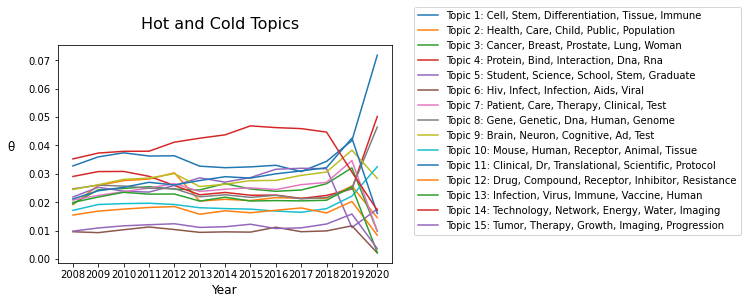

In [20]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)
for n in range(num_topics):
    linear_fit = lm().fit(topic_frame["FY"].values.reshape(-1,1),topic_frame[n].values.reshape(-1,1))
    topic_results[n] = linear_fit.coef_[0][0]
    print("Topic %d R^2: %r"%(n+1,linear_fit.score(topic_frame["FY"].values.reshape(-1,1),topic_frame[n].values.reshape(-1,1))))
    ax.plot(topic_frame["FY"],topic_frame[n])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_frame["FY"].min(), topic_frame["FY"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('θ', fontsize=12, rotation = 0)
ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [30]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]


['Topic 1: Cell, Stem, Differentiation, Tissue, Immune', 'Topic 11: Clinical, Dr, Translational, Scientific, Protocol', 'Topic 9: Brain, Neuron, Cognitive, Ad, Test', 'Topic 8: Gene, Genetic, Dna, Human, Genome', 'Topic 10: Mouse, Human, Receptor, Animal, Tissue']


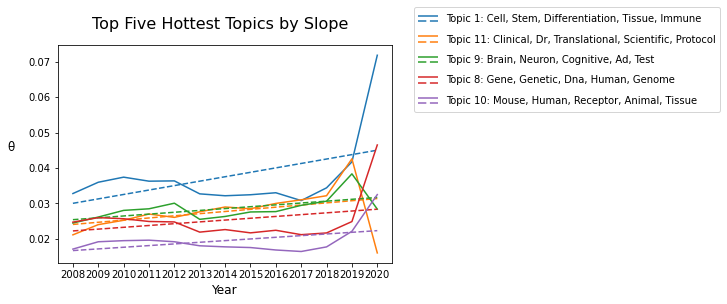

In [104]:
#Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Topics by Slope', fontsize=16)
ax = fig.add_subplot(111)
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    linear_fit = lm().fit(topic_frame["FY"].values.reshape(-1,1),topic_frame[n].values.reshape(-1,1))
    ax.plot(topic_frame["FY"],(topic_frame["FY"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_frame["FY"],topic_frame[n])
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_frame["FY"].min(), topic_frame["FY"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('θ', fontsize=12, rotation = 0)
ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

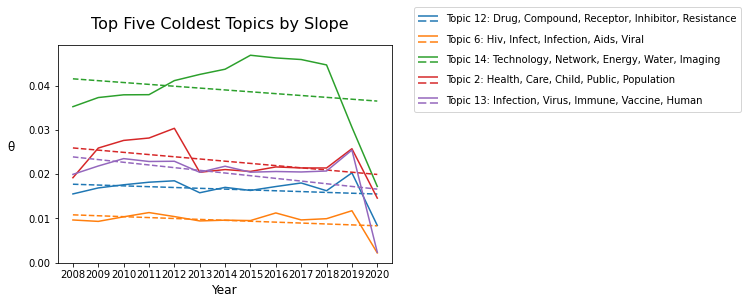

In [105]:
#Make Graphs
#leg = []
line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Topics by Slope', fontsize=16)
ax = fig.add_subplot(111)
i = 0
for n in bottom_slopes:
    linear_fit = lm().fit(topic_frame["FY"].values.reshape(-1,1),topic_frame[n].values.reshape(-1,1))
    ax.plot(topic_frame["FY"],(topic_frame["FY"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_frame["FY"],topic_frame[n])
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_frame["FY"].min(), topic_frame["FY"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('θ', fontsize=12, rotation = 0)
ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
plt.legend(line_return, [leg[x] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')

#plt.legend([leg[x] for x in top_slopes],bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()